# Including

In [1]:
using NBInclude
using Plots
using LaTeXStrings
using SparseArrays
using DataFrames
using ProgressBars
using Interpolations;
using LinearAlgebra
@nbinclude("Hofstadter Single Particle in Julia.ipynb")
@nbinclude(joinpath("..","First Band Approximation Functions.ipynb"))
@nbinclude(joinpath("../Braiding Utils.ipynb"))
@nbinclude("../Aharonov-Bohm Phase.ipynb");

# Model Parameters

$\phi=\frac{p}{q}=\frac{p}{N_y}, N_\phi=\phi NxNy=N_x \text{ (The number of single particle degeneracy)}$

In [82]:
Nx=8
Ny=10
N=Nx*Ny
p=1
q=Ny
NPhi = Int( Nx * Ny * (p/q) )
cut_off = Nx
PN = [0, 1, 2, 3]
U = 4;

Nx=10
Ny=10
N=Nx*Ny
p=1
q=2
NPhi = Int( Nx * Ny * (p/q) )
cut_off = Nx
PN = [0, 1, 2, 3]
U = 4;
Bu set için GS dejenere gelmedi ve quasi-hole pinlenmedi. GS dejenere katlılığının çok büyük olması ile ilgisi var mı?

# Sub Space Kinetic Term

In [83]:
function H_sp(N, Nx, Ny, p, q)
    sp_basis = NLevelBasis(N)
    periodicity = 0 #periodic (select 1 for hard-wall conditions)
    sp_matrix = Hofstadter_SP(Nx, Ny, p/q, periodicity)
    H1 = get_sp_op(sp_basis, sp_matrix)
    return H1, sp_basis
end

H_sp (generic function with 1 method)

In [84]:
H1, sp_basis = H_sp(N, Nx, Ny, p, q);

In [85]:
function H_sub(N, Nx, Ny, p, q, H1, cut_off, sp_basis)
    sub_states = get_sub_states(H1, cut_off)
    basis_sub, P, Pt = get_projector_op(sub_states, sp_basis)
    H1_sub = get_subspace_op(H1, P, Pt)
    return H1_sub, basis_sub, P, Pt
end

H_sub (generic function with 1 method)

In [86]:
H1_sub, basis_sub, P, Pt = H_sub(N, Nx, Ny, p, q, H1, cut_off, sp_basis);

In [87]:
function H_Kin_MB(N, Nx, Ny, p, q, cut_off, PN)
    states_mb = bosonstates(basis_sub, PN) 
    basis_mb = ManyBodyBasis(basis_sub, states_mb)
    H1_MB = get_mb_op(basis_mb, H1_sub)
    return H1_MB
end

H_Kin_MB (generic function with 1 method)

In [88]:
@nbinclude("Hofstadter MB in Julia.ipynb"; regex=r"#.*executeme");

In [89]:
basis_cut_mb, basis_cut_sp = get_Bosonic_MB_Basis(cut_off, PN);

In [90]:
function H_Total_Sub(N, Nx, Ny, p, q, cut_off, PN, U, basis_cut_mb)
    H_Kin = SparseOperator(basis_cut_mb)
    H1_MB = H_Kin_MB(N, Nx, Ny, p, q, cut_off, PN)
    H_Kin.data = H1_MB.data
    H_Int = Hubbard_Interaction_op(P, Pt, basis_cut_mb, cut_off, U)
    return H_Kin, H_Kin + H_Int
end

H_Total_Sub (generic function with 1 method)

# Sub Space Hubbard Interaction Term

In [91]:
H_Kin, Total_H = H_Total_Sub(N, Nx, Ny, p, q, cut_off, PN, U, basis_cut_mb);

0.0%┣                                                ┫ 0/8 [00:00<00:00, -0s/it]
25.0%┣███████████▊                                   ┫ 2/8 [00:00<00:00, 18it/s]
87.5%┣█████████████████████████████████████████▏     ┫ 7/8 [00:00<00:00, 53it/s]
100.0%┣██████████████████████████████████████████████┫ 8/8 [00:00<00:00, 55it/s]
100.0%┣██████████████████████████████████████████████┫ 8/8 [00:00<00:00, 55it/s]


# Total Hamiltonian with Impurity Potential

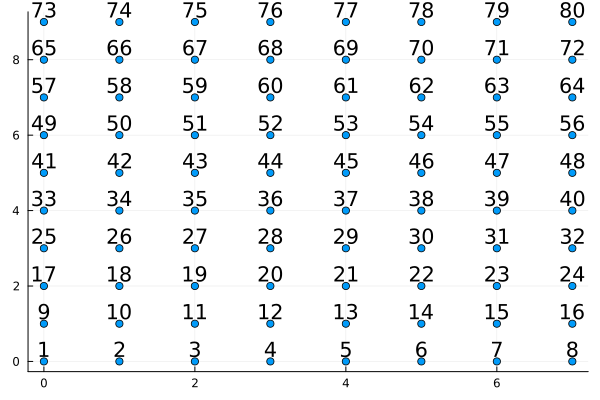

([0 0; 1 0; … ; 6 9; 7 9], nothing)

In [92]:
plot_square_lattice(Nx, Ny)

For particle pinning: V0<0 & PN = 1, U = 0!

In [93]:
V0 = [4, 0]; Imp_Site = [19, 62]
Impurity_Data = Impurity(V0, Imp_Site);

In [94]:
function Number_sub(N, sp_basis, P, Pt, basis_cut_sp, basis_cut_mb, basis_sub)
    num_sub_list = get_num_sub_list(N, sp_basis, P, Pt)
    Sub_Number_MB_Operator_List = get_num_mb_op(N, basis_cut_sp, num_sub_list, basis_cut_mb, basis_sub)
    return Sub_Number_MB_Operator_List
end

Number_sub (generic function with 1 method)

In [95]:
Sub_Number_MB_Operator_List = Number_sub(N, sp_basis, P, Pt, basis_cut_sp, basis_cut_mb, basis_sub);

0.0%┣                                               ┫ 0/80 [00:00<00:00, -0s/it]
100.0%┣█████████████████████████████████████████┫ 80/80 [00:00<00:00, 39.4kit/s]
100.0%┣█████████████████████████████████████████┫ 80/80 [00:00<00:00, 38.6kit/s]


In [96]:
function get_H_Impurity(N, sp_basis, P, Pt, basis_cut_sp, basis_cut_mb, basis_sub, Total_H, Sub_Number_MB_Operator_List, Impurity_Data)
    H_Impurity = Imp_H(Total_H, Sub_Number_MB_Operator_List, Impurity_Data)
    H_Impurity = dense((H_Impurity'+H_Impurity)/2);
    return H_Impurity
end

get_H_Impurity (generic function with 1 method)

In [97]:
H_Impurity = get_H_Impurity(N, sp_basis, P, Pt, basis_cut_sp, basis_cut_mb, basis_sub, Total_H, Sub_Number_MB_Operator_List, Impurity_Data);

In [98]:
# SP IMPURITY

In [99]:
# VV = zeros(Nx*Ny,Nx*Ny)
# site = Impurity_Data.Imp_Site[1]
# VV[site, site] = Impurity_Data.V0[1] # full localised single particle
# VV = Operator(sp_basis,sp_basis,VV);

In [100]:
# H_imp_SP = H1 + VV;

In [101]:
# sub_states = get_sub_states(H_imp_SP, cut_off)
# basis_sub, P, Pt = get_projector_op(sub_states, sp_basis)
# H_imp_sp_sub = get_subspace_op(H_imp_SP, P, Pt)
# H_imp_sp_sub = (H_imp_sp_sub' + H_imp_sp_sub)/2;

In [102]:
# E_sp_sub, V_sp_sub = eigenstates(H_imp_sp_sub);
# scatter(E_sp_sub)

\begin{align*}
    &\text{Filling fraction:} \quad \nu=\frac{N}{N_{\Phi}} = \frac{3}{8}, \quad \text{Laughlin fraction: } \frac{N}{N_{\Phi}}=\frac{3}{6}=\frac{1}{2} => \text{There are 2 free quasi-particles.} \\
    &\text{So, added 2 flux in the lattice is mean that, +2 free quasi-particles. One of them is pinned.}
\end{align*}

# Exact Diagonalization

In [103]:
N_Pin = 1

1

In [104]:
function ground_degeneracy(N_Pin, nu0, PN)
    NPhi0 = Nx*Ny*(p/q)
    NPhi = NPhi0-N_Pin
    pn = maximum(PN)
    N_d = Int(NPhi - pn/nu0)
    Degeneracy = Int((factorial(N_d + pn - 1) / (factorial(N_d) * factorial(pn - 1))) * (NPhi / pn))
    return Degeneracy
end

ground_degeneracy (generic function with 1 method)

In [105]:
if length(PN) != 1
    nu0 = 1/2
    Degeneracy = ground_degeneracy(N_Pin, nu0, PN)
else
    Degeneracy = 1
end

7

In [106]:
Degeneracy

7

In [107]:
function energies_imp(H_Impurity, PN, basis_cut_mb)
    E, V = eigenstates(H_Impurity)
    pn = maximum(PN)
    filtered_energies = get_filtered_energies(pn, E, V, basis_cut_mb)
    return filtered_energies, V
end

energies_imp (generic function with 1 method)

In [108]:
# PN = 1 İken (AB faz hesaplarken) sadece bir parçacık var o yüzden filter yapmayacağız!!!

In [109]:
filtered_energies, V = energies_imp(H_Impurity, PN, basis_cut_mb);

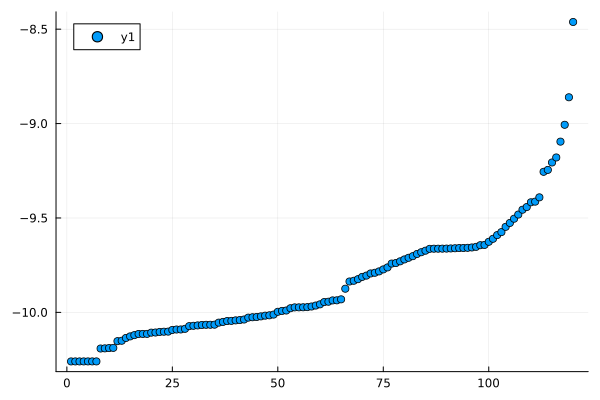

In [110]:
scatter(filtered_energies)

In [111]:
# Onur hocanın makalesinde ki FIG1 çıktısı

# using Plots
# using LaTeXStrings
# Plots.plot(1:35, E0, seriestype=:scatter,xlabel=L"$n$",ylabel=L"$E$",title=L"$V_{imp}=0$",legend=false)
# #ylims!((-7.20544,-7.20536))

Alltaki fonksiyonun çalışması için, dizideki filtre edilmiş parçacık sayısı her zaman en büyük değerde olmalıdır.
Örneğin, `PN=[0,1,2,3,4]` iken filtre edilen parçacık sayısı `pn=4` olmalıdır!

# Density Profile

In [112]:
filtered_energies;

In [113]:
r_hubbard_states = Restricted_Hubbard_States(V, filtered_energies);

In [114]:
function plot_density(Nx, Ny, Degeneracy, N, Sub_Number_MB_Operator_List, basis_cut_mb, r_hubbard_states, factor)
    avg_density = Get_Avg_Density(Nx, Ny, Degeneracy, N, Sub_Number_MB_Operator_List, basis_cut_mb, r_hubbard_states)
    return Plots.heatmap(Interp(avg_density', factor), aspect_ratio=:equal)
end

plot_density (generic function with 1 method)

In [115]:
avg_density = Get_Avg_Density(Nx, Ny, Degeneracy, N, Sub_Number_MB_Operator_List, basis_cut_mb, r_hubbard_states);

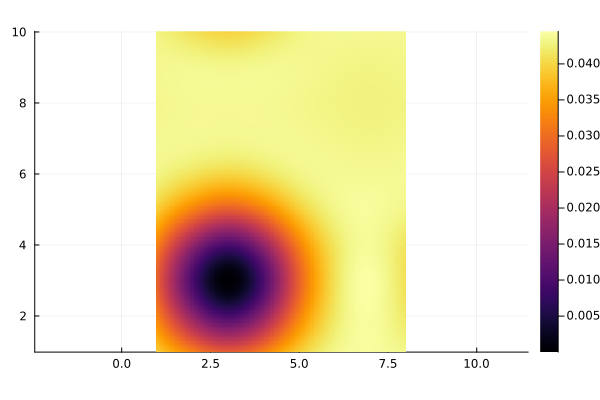

In [116]:
factor = 25
plot_density(Nx, Ny, Degeneracy, N, Sub_Number_MB_Operator_List, basis_cut_mb, r_hubbard_states, factor)
#scatter!(co[:,1].+1,co[:,2].+1, series_annotations = text.([i for i in 1:N], :bottom), legend=false)

# Braiding and AB Phase Calculations

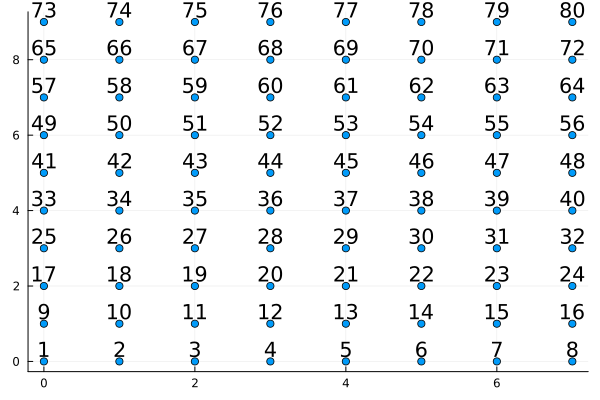

([0 0; 1 0; … ; 6 9; 7 9], nothing)

In [117]:
plot_square_lattice(Nx, Ny)

In [118]:
start_point_1 = Impurity_Data.Imp_Site[1]

19

In [119]:
lens_1 = [3, 5, 3, 5]
dirs_1 = [1, Nx, -1, -Nx]
rec_path_1 = unique(rectangular_path(start_point_1,lens_1,dirs_1))
rec_path_1 = push!(rec_path_1,start_point_1)

17-element Vector{Int64}:
 19
 20
 21
 22
 30
 38
 46
 54
 62
 61
 60
 59
 51
 43
 35
 27
 19

In [120]:
start_point_2 = Impurity_Data.Imp_Site[2]

62

In [121]:
lens_2 = [3, 5, 3, 5]
dirs_2 = [-1, -Nx, 1, Nx]
rec_path_2 = unique(rectangular_path(start_point_2,lens_2,dirs_2))
rec_path_2 = push!(rec_path_2,start_point_2)

17-element Vector{Int64}:
 62
 61
 60
 59
 51
 43
 35
 27
 19
 20
 21
 22
 30
 38
 46
 54
 62

In [122]:
N_Pin = 4 # Burada ki N_Pin ile yukarıda tanımladığımız N_Pin farklılar!
V1 = Impurity_Data.V0[1]
V2 = 0;
V2 = Impurity_Data.V0[2]

0.0

In [123]:
Imp_Site = [rec_path_1[1], rec_path_1[2], rec_path_2[1], rec_path_2[2]]
V0 = [V1, 0, V2, 0]
Impurity_Data = Impurity(V0, Imp_Site);

In [124]:
Impurity_H = Imp_H(Total_H, Sub_Number_MB_Operator_List, Impurity_Data)
Impurity_H = dense((Impurity_H+Impurity_H')/2);

In [125]:
E_Imp_0, U_Imp_0 = eigenstates(Impurity_H)
U_Imp_0 = hcat([U_Imp_0[i].data for i in 1:Degeneracy] ...);

In [126]:
U_first = copy(U_Imp_0);

In [127]:
delta_t = 0.01
STEP = 0:delta_t:1
length(STEP)

101

In [128]:
Imp_Site_List = [ [imp, rec_path_1[idx+1], rec_path_2[idx], rec_path_2[idx+1] ] for (idx,imp) in (enumerate(rec_path_1[1:end-1])) ]
V0_List = [ [V1*(1-step), V1*step, V2*(1-step), V2*step] for step in STEP ];

In [129]:
Impurity_Data_List = [ [Impurity(V00, Imp_Sitee)] for Imp_Sitee in Imp_Site_List for V00 in V0_List ];

In [130]:
Impurity_H_List = [ Imp_H(Total_H, Sub_Number_MB_Operator_List, Impurity_Dataa[1]) for Impurity_Dataa in ProgressBar(Impurity_Data_List) ];

0.0%┣                                            ┫ 0/1.6k [00:00<00:-18, -0s/it]
4.5%┣██                                        ┫ 73/1.6k [00:00<00:01, 1.2kit/s]
33.5%┣█████████████▍                          ┫ 541/1.6k [00:00<00:00, 4.8kit/s]
53.6%┣█████████████████████▍                  ┫ 866/1.6k [00:00<00:00, 5.4kit/s]
73.5%┣████████████████████████████▋          ┫ 1.2k/1.6k [00:00<00:00, 5.6kit/s]
93.9%┣████████████████████████████████████▋  ┫ 1.5k/1.6k [00:00<00:00, 5.8kit/s]
100.0%┣██████████████████████████████████████┫ 1.6k/1.6k [00:00<00:00, 5.8kit/s]
100.0%┣██████████████████████████████████████┫ 1.6k/1.6k [00:00<00:00, 5.8kit/s]


In [131]:
function U_Imp_0_Ket(U_Imp_0)
    Eigen_List = []
    U_IMP_0_List = []
    for Impurity_HH in ProgressBar(Impurity_H_List)
        Impurity_HH = dense((Impurity_HH+Impurity_HH')/2)
        E_Imp, U_Imp = eigenstates(Impurity_HH)
        push!(Eigen_List, U_Imp)
        U_Imp = hcat([U_Imp[i].data for i in 1:Degeneracy] ...)
        A = U_Imp_0'*U_Imp
        A_inv = inv(A)
        U_Imp_0 = U_Imp*A_inv
        # for i in 1:Degeneracy
        #     Norm_0 = sqrt(U_Imp_0[:,i]'*U_Imp_0[:,i])
        #     U_Imp_0[:,i] = U_Imp_0[:,i] ./ Norm_0
        # end
        #global U_Imp_0 = gram_schmidt(U_Imp_0)
    end
    return U_Imp_0, Eigen_List, U_IMP_0_List
end

U_Imp_0_Ket (generic function with 1 method)

In [132]:
U_Imp_0, Eigen_List, U_IMP_0_List = U_Imp_0_Ket(U_Imp_0);

0.0%┣                                             ┫ 0/1.6k [00:00<00:00, -0s/it]
0.1%┣                                         ┫ 1/1.6k [00:00<Inf:Inf, InfGs/it]
0.8%┣▍                                           ┫ 13/1.6k [00:00<00:22, 74it/s]
1.6%┣▊                                          ┫ 26/1.6k [00:00<00:14, 116it/s]
2.4%┣█                                          ┫ 39/1.6k [00:00<00:11, 143it/s]
3.3%┣█▍                                         ┫ 54/1.6k [00:00<00:09, 167it/s]
4.3%┣█▉                                         ┫ 69/1.6k [00:00<00:08, 184it/s]
5.2%┣██▎                                        ┫ 84/1.6k [00:00<00:08, 197it/s]
6.1%┣██▋                                        ┫ 99/1.6k [00:00<00:07, 208it/s]
7.1%┣███                                       ┫ 114/1.6k [00:01<00:07, 216it/s]
8.0%┣███▍                                      ┫ 129/1.6k [00:01<00:07, 223it/s]
8.9%┣███▊                                      ┫ 144/1.6k [00:01<00:06, 228it/s]
9.8%┣████▏                  

In [133]:
BerryEnergies, BerryStates = eigen(U_Imp_0' * U_first)
Θ = angle.(BerryEnergies)/pi

7-element Vector{Float64}:
 -0.7590493171697305
 -0.7315974876505751
  0.6898770566370135
  0.6620763994307819
  0.4138033598097666
  0.37581100956999564
  0.349078979372801

In [134]:
sum(Θ)

1.0000000000000533

In [55]:
Degeneracy

LoadError: UndefVarError: `Degeneracy` not defined

In [56]:
data1 = Get_Avg_Density(Nx, Ny, Degeneracy, N, Sub_Number_MB_Operator_List, basis_cut_mb, Eigen_List[1])'
heatmap(Interp(data1, 1), aspect_ratio=:equal)

LoadError: UndefVarError: `Degeneracy` not defined

# Single Particle Brading with Tanh Potential

In [57]:
# Not: Kodun başında ki parametreler SP için OLMALI!

In [58]:
# co = vcat( ( [y x] for x in 0:Ny-1 for y in 0:Nx-1 ) ... );

In [59]:
# plot_square_lattice(Nx, Ny)

In [60]:
# x0, y0 = co[18,:]
# x1, y1 = co[20,:]
# x2, y2 = co[48,:]
# x3, y3 = co[46,:]
# coord = [x0, y0, x1, y1, x2, y2, x3, y3];

In [61]:
# mutable struct impurity
#     V0::Float64
#     pos::Array{Float64}
#     wid::Float64
# end

In [62]:
# V0 = 10
# wid = 0.1
# imps = [impurity(V0, [x0,y0], wid) ];

In [63]:
# function Vpin2(imp, N, co)
#     VV   = zeros(N,N)
#     for site in 1:N
#         VV[site, site] = imp.V0*(tanh( norm( co[site,:] - imp.pos ) / imp.wid )^2 -1)
#     end
#     return VV
# end

In [64]:
# function Vimp2(imps, N, co)
#     VM   = zeros(N,N)
#     for imp in imps 
#         VM +=  Vpin2(imp, N, co)
#     end
#     return VM
# end

In [65]:
# function Himp(imps, N, co, basis, H1)
#     VimpM = Vimp2(imps, N, co)
#     Vimp_op = get_sp_op(basis, VimpM)
#     return H1 + Vimp_op
# end

In [66]:
# H1_tanh = Himp(imps, N, co, sp_basis, H1);

In [67]:
# E_0, U_0 = eigenstates(dense(H1_tanh));

In [68]:
# θ, ψ_list = get_ab_phase2(coord, 0.1, V0, wid, N, co, sp_basis, H1, U_0, Degeneracy);

In [69]:
# θ